### Unzip Dataset
Unzips the provided dataset archive for the hiring assessment.

In [ ]:
!unzip -q "/content/shl-intern-hiring-assessment-2025.zip" -d "/content/"

### Install Required Libraries
Installs necessary Python libraries including `openai-whisper` for speech-to-text, `nltk` for natural language processing, `scikit-learn` for machine learning, and `librosa` for audio analysis.

In [ ]:
!pip install -q openai-whisper nltk scikit-learn librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 3.5 MB/s eta 0:00:00


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/dataset/csvs/test.csv
/content/dataset/csvs/train.csv
/content/dataset/audios/train/audio_40_2.wav
/content/dataset/audios/train/audio_353.wav
/content/dataset/audios/train/audio_347.wav
/content/dataset/audios/train/audio_42.wav
/content/dataset/audios/train/audio_64_2.wav
/content/dataset/audios/train/audio_89.wav
/content/dataset/audios/train/audio_308.wav
/content/dataset/audios/train/audio_20.wav
/content/dataset/audios/train/audio_171.wav
/content/dataset/audios/train/audio_245.wav
/content/dataset/audios/train/audio_168.wav
/content/dataset/audios/train/audio_77_2.wav
/content/dataset/audios/train/audio_224.wav
/content/dataset/audios/train/audio_147.wav
/content/dataset/audios/train/audio_34_2.wav
/content/dataset/audios/train/audio_65.wav
/content/dataset/audios/train/audio_83.wav
/content/dataset/audios/train/audio_53.wav
/content/dataset/audios/train/audio_275.wav
/content/dataset/audios/train/audio_79.wav
/content/dataset/audios/train/audio_130.wav
/content/dataset

### Import Core Libraries and Explore Dataset
Imports essential data manipulation libraries (`numpy`, `pandas`, `os`) and lists the files within the `/content/dataset` directory to provide an overview of the dataset structure.

In [ ]:
import os
import whisper
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

### Initialize NLTK and Whisper Model
Imports required libraries, downloads specific NLTK resources (`punkt`, `averaged_perceptron_tagger`), and loads the `base` Whisper model for subsequent audio transcription.

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

model = whisper.load_model("base")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Define Data Paths and Load Metadata
Sets up base paths for audio and CSV files, loads the training and testing metadata into pandas DataFrames, and defines a utility function `get_audio_filepath` to construct full paths to audio files.

In [ ]:
BASE_PATH = "/content/dataset"

TRAIN_AUDIO = os.path.join(BASE_PATH, "audios/train")
TEST_AUDIO  = os.path.join(BASE_PATH, "audios/test")

train_df = pd.read_csv(os.path.join(BASE_PATH, "csvs/train.csv"))
test_df  = pd.read_csv(os.path.join(BASE_PATH, "csvs/test.csv"))

def get_audio_filepath(base, filename):
    return os.path.join(base, filename + ".wav")

## Visualize Target Label Distribution

### Subtask:
Create a histogram and a kernel density estimate (KDE) plot of the 'label' column from `train_df` to visualize its distribution.


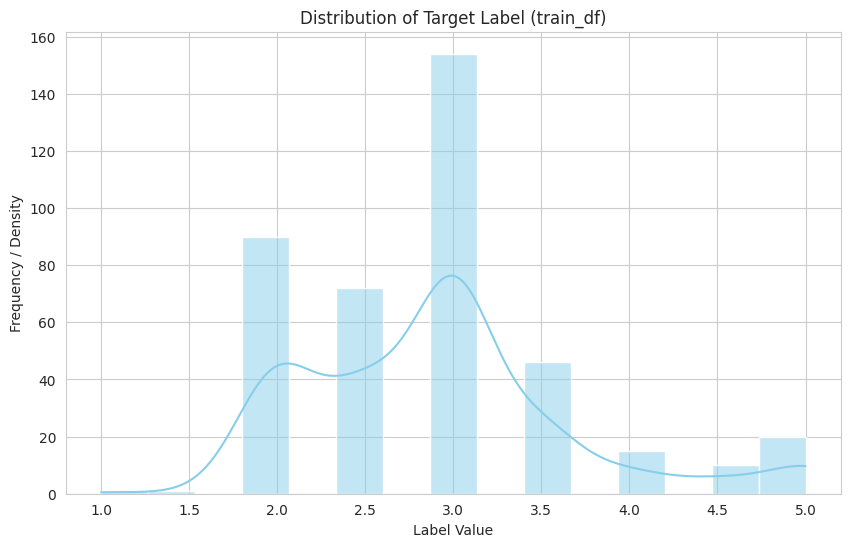

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(train_df['label'], kde=True, bins=15, color='skyblue')
plt.title('Distribution of Target Label (train_df)')
plt.xlabel('Label Value')
plt.ylabel('Frequency / Density')
plt.show()

### Define Feature Extraction Function
Defines the `extract_features` function, which transcribes an audio file using the Whisper model and then extracts linguistic features (total words, number of nouns, verbs, adjectives, average word length) using NLTK.

In [ ]:
def extract_features(audio_path):
    result = model.transcribe(audio_path, fp16=False)
    text = result['text'].strip()

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    total_words = len(tokens)
    num_nouns = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    num_verbs = sum(1 for word, tag in pos_tags if tag.startswith('VB'))
    num_adjs = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))
    avg_word_len = sum(len(word) for word in tokens) / total_words if total_words else 0

    return {
        'text': text,
        'total_words': total_words,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs,
        'num_adjs': num_adjs,
        'avg_word_len': avg_word_len
    }

### Extract Features for Training Data
Processes all audio files in the training dataset, transcribing each and extracting linguistic features using the `extract_features` function. It also associates each set of features with its corresponding label.

In [ ]:
train_features = []

for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    audio_filename_base = row['filename']
    full_audio_path = get_audio_filepath(TRAIN_AUDIO, audio_filename_base)  # Use the renamed helper function

    try:
        features = extract_features(full_audio_path)
        features['label'] = row['label']
        train_features.append(features)
    except Exception as e:
        print(f"❌ Failed to process {audio_filename_base}: {e}")

100%|██████████| 409/409 [1:31:24<00:00, 13.41s/it]


### Create Training Feature DataFrame
Converts the list of extracted training features into a pandas DataFrame (`train_feat_df`), which will be used for model training.

In [ ]:
import pandas as pd
train_feat_df = pd.DataFrame(train_features)

### Prepare Data for RandomForest Training
Selects the linguistic features from `train_feat_df` to form the feature matrix `X` and extracts the 'label' column as the target variable `y` for the RandomForest model. Initializes and trains a `RandomForestRegressor`.

In [ ]:
X = train_feat_df[['total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len']]
y = train_feat_df['label']

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X, y)

RandomForestRegressor(random_state=42)

### Evaluate RandomForest Training Performance
Uses the trained `RandomForestRegressor` to predict labels on the training data (`X`) and calculates the Mean Squared Error (MSE) to assess its performance.

In [ ]:
y_pred = model_rf.predict(X)
mse = mean_squared_error(y, y_pred)
print(f"Train MSE: {mse:.4f}")

Train MSE: 0.0801


### Extract Features for Test Data
Processes all audio files in the test dataset, transcribing each and extracting linguistic features using the `extract_features` function.

In [ ]:
test_features = []

for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    audio_filename_base = row['filename']
    full_audio_path = get_audio_filepath(TEST_AUDIO, audio_filename_base)  # Use the renamed helper function

    try:
        features = extract_features(full_audio_path)
        # Removed the line trying to access 'label' from test_df, as test_df does not have a 'label' column
        test_features.append(features)
    except Exception as e:
        print(f"❌ Failed to process {audio_filename_base}: {e}")

100%|██████████| 197/197 [39:06<00:00, 11.91s/it]


### Prepare Test Feature DataFrame
Converts the list of extracted test features into a pandas DataFrame (`test_feat_df`) and selects the linguistic features to form the test feature matrix `X_test`.

In [ ]:
test_feat_df = pd.DataFrame(test_features)
X_test = test_feat_df[['total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len']]


### Generate RandomForest Predictions and Submission File
Uses the trained `RandomForestRegressor` (`model_rf`) to make predictions on the `X_test` features and creates a `submission.csv` file with the filenames and predicted labels.

In [ ]:
preds = model_rf.predict(X_test)
submission = pd.DataFrame({'filename': test_df['filename'], 'label': preds})
submission.to_csv("submission.csv", index=False)
submission.head()

,filename,label
0,audio_141,2.800
1,audio_114,2.515
2,audio_17,2.760
3,audio_76,3.205
4,audio_156,2.835


### Save Extracted Features to CSV
Saves the `train_feat_df` and `test_feat_df` DataFrames to CSV files (`train_features.csv`, `test_features.csv`) for future use, preventing the need to re-run time-consuming feature extraction.

In [ ]:
# Save the feature DataFrames to CSV files
train_feat_df.to_csv('train_features.csv', index=False)
test_feat_df.to_csv('test_features.csv', index=False)

print("Train features saved to 'train_features.csv'")
print("Test features saved to 'test_features.csv'")

Train features saved to 'train_features.csv'
Test features saved to 'test_features.csv'


### Load Previously Saved Features
Loads the previously saved `train_features.csv` and `test_features.csv` files into new pandas DataFrames (`loaded_train_feat_df`, `loaded_test_feat_df`).

In [ ]:
import pandas as pd

# Load saved train and test features
loaded_train_feat_df = pd.read_csv('train_features.csv')
loaded_test_feat_df = pd.read_csv('test_features.csv')

print("Loaded train features head:")
display(loaded_train_feat_df.head())

print("\nLoaded test features head:")
display(loaded_test_feat_df.head())

Loaded train features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5



Loaded test features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714
4,The best day of my life are the most days when...,69,13,15,3,4.072464


### Install Boosting Libraries
Installs the `xgboost`, `catboost`, and `lightgbm` Python libraries.

In [ ]:
!pip install -q xgboost catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


### Verify Data Preparation
Displays the head and shape of the training features (`X`), target variable (`y`), and test features (`X_test`) to confirm they are correctly prepared for model training.

In [ ]:
print("Training Features (X) Head:")
display(X.head())
print("Training Features (X) Shape:", X.shape)

print("\nTarget Variable (y) Head:")
display(y.head())
print("Target Variable (y) Shape:", y.shape)

print("\nTest Features (X_test) Head:")
display(X_test.head())
print("Test Features (X_test) Shape:", X_test.shape)

Training Features (X) Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len
0,110,17,21,7,3.781818
1,159,41,29,12,4.459119
2,68,16,10,6,3.838235
3,96,22,19,8,4.770833
4,139,23,23,8,3.071942


Training Features (X) Shape: (409, 5)

Target Variable (y) Head:


,label
0,3.0
1,3.0
2,2.0
3,2.0
4,3.5


Target Variable (y) Shape: (409,)

Test Features (X_test) Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len
0,39,17,4,1,4.076923
1,57,11,9,5,3.649123
2,85,16,18,3,3.894118
3,154,41,19,2,3.785714
4,69,13,15,3,4.072464


Test Features (X_test) Shape: (197, 5)


### Train and Evaluate XGBoost Model
Initializes and trains an `XGBRegressor` model on the prepared training data (`X`, `y`). It then predicts on the training data and calculates the Mean Squared Error (MSE).

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBRegressor(random_state=42)
model_xgb.fit(X, y)

y_pred_xgb = model_xgb.predict(X)
mse_xgb = mean_squared_error(y, y_pred_xgb)
print(f"XGBoost Train MSE: {mse_xgb:.4f}")

XGBoost Train MSE: 0.0003


### Train and Evaluate CatBoost Model
Initializes and trains a `CatBoostRegressor` model on the prepared training data (`X`, `y`). It then predicts on the training data and calculates the Mean Squared Error (MSE).

In [ ]:
import catboost as cb

model_cb = cb.CatBoostRegressor(random_state=42, verbose=0) # verbose=0 to suppress output during training
model_cb.fit(X, y)

y_pred_cb = model_cb.predict(X)
mse_cb = mean_squared_error(y, y_pred_cb)
print(f"CatBoost Train MSE: {mse_cb:.4f}")

CatBoost Train MSE: 0.0552


### Train and Evaluate LightGBM Model
Initializes and trains an `LGBMRegressor` model on the prepared training data (`X`, `y`). It then predicts on the training data and calculates the Mean Squared Error (MSE).

In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(random_state=42)
model_lgb.fit(X, y)

y_pred_lgb = model_lgb.predict(X)
mse_lgb = mean_squared_error(y, y_pred_lgb)
print(f"LightGBM Train MSE: {mse_lgb:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 5
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

### Compare All Models and Select Best
Compares the training Mean Squared Error (MSE) of all models (RandomForest, XGBoost, CatBoost, LightGBM) to identify the best performing one based on the lowest MSE.

In [ ]:
print(f"RandomForest Train MSE: {mse:.4f}")
print(f"XGBoost Train MSE: {mse_xgb:.4f}")
print(f"CatBoost Train MSE: {mse_cb:.4f}")
print(f"LightGBM Train MSE: {mse_lgb:.4f}")

# Determine the best model
mse_values = {
    'RandomForest': mse,
    'XGBoost': mse_xgb,
    'CatBoost': mse_cb,
    'LightGBM': mse_lgb
}

best_model_name = min(mse_values, key=mse_values.get)
best_mse = mse_values[best_model_name]

print(f"\nThe best performing model based on training MSE is {best_model_name} with MSE: {best_mse:.4f}")

RandomForest Train MSE: 0.0801
XGBoost Train MSE: 0.0003
CatBoost Train MSE: 0.0552
LightGBM Train MSE: 0.1648

The best performing model based on training MSE is XGBoost with MSE: 0.0003


### Generate Predictions with Best Model and Submission File
Uses the identified best model (XGBoost) to make predictions on the test data (`X_test`) and creates a `submission.csv` file with the filenames and predicted labels.

In [ ]:
best_model = model_xgb
preds_best_model = best_model.predict(X_test)

submission_best_model = pd.DataFrame({'filename': test_df['filename'], 'label': preds_best_model})
submission_best_model.to_csv("submission.csv", index=False)

print(f"Predictions made using the best model ({best_model_name}).")
print("Submission file created: submission.csv")
display(submission_best_model.head())

Predictions made using the best model (XGBoost).
Submission file created: submission.csv


,filename,label
0,audio_141,2.657021
1,audio_114,2.708885
2,audio_17,2.788728
3,audio_76,2.573682
4,audio_156,2.841169


### Install Transformers Library
Installs the Hugging Face `transformers` library, which is essential for working with BERT models.

In [ ]:
!pip install -q transformers

### Load Pre-trained BERT Model and Tokenizer
Initializes a pre-trained `bert-base-uncased` tokenizer and model from the `transformers` library. The model is then moved to the CPU for processing.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"BERT Tokenizer and Model initialized successfully. Model moved to {device}.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Tokenizer and Model initialized successfully. Model moved to cpu.


### Load Existing Features for BERT Enhancement
Loads the previously saved training and testing feature DataFrames (`train_features.csv` and `test_features.csv`) as `loaded_train_feat_df` and `loaded_test_feat_df`.

In [ ]:
import pandas as pd
loaded_train_feat_df = pd.read_csv('train_features.csv')
loaded_test_feat_df = pd.read_csv('test_features.csv')

print("Loaded train features head:")
display(loaded_train_feat_df.head())

print("\nLoaded test features head:")
display(loaded_test_feat_df.head())

Loaded train features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5



Loaded test features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714
4,The best day of my life are the most days when...,69,13,15,3,4.072464


### Define BERT Embedding Extraction Function
Defines the `extract_bert_embeddings` function, which tokenizes a given text, passes it through the loaded BERT model, and returns a flattened NumPy array representing the BERT embedding of the `[CLS]` token.

In [ ]:
import numpy as np

def extract_bert_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    cls_embedding = output.last_hidden_state[:, 0, :]
    return cls_embedding.cpu().numpy().flatten()
print("Function `extract_bert_embeddings` defined successfully.")

Function `extract_bert_embeddings` defined successfully.


### Extract and Add BERT Embeddings to Training Data
Iterates through the `text` column of `loaded_train_feat_df` to extract BERT embeddings for each text entry. These embeddings are then added as new columns to the DataFrame, enhancing the training feature set.

In [ ]:
print("Extracting BERT embeddings for training data...")

train_bert_embeddings = []
loaded_train_feat_df['text'] = loaded_train_feat_df['text'].fillna('')

for text_entry in tqdm(loaded_train_feat_df['text'], desc="Extracting train BERT embeddings"):
    try:
        embedding = extract_bert_embeddings(text_entry)
        train_bert_embeddings.append(embedding)
    except Exception as e:
        print(f"Error extracting embedding for text: '{text_entry[:50]}...' - {e}")
        train_bert_embeddings.append(np.zeros(768))

train_bert_embeddings_df = pd.DataFrame(train_bert_embeddings, columns=[f'bert_embedding_{i}' for i in range(len(train_bert_embeddings[0]))])

loaded_train_feat_df = pd.concat([loaded_train_feat_df, train_bert_embeddings_df], axis=1)

print("BERT embeddings added to loaded_train_feat_df.")
display(loaded_train_feat_df.head())

Extracting BERT embeddings for training data...


Extracting train BERT embeddings: 100%|██████████| 409/409 [03:01<00:00,  2.26it/s]

BERT embeddings added to loaded_train_feat_df.


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label,bert_embedding_0,bert_embedding_1,bert_embedding_2,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0,-0.017884,-0.220572,-0.082134,...,-0.580587,-0.751241,0.145468,-0.359172,0.179437,-0.136312,-0.062331,-0.370403,0.830012,0.192308
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0,-0.157179,-0.173512,0.235440,...,-0.350523,-0.236923,-0.195590,-0.108573,0.065613,-0.439462,-0.228660,-0.357835,0.725449,-0.235447
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0,-0.059833,-0.192255,0.035728,...,0.048796,-0.212610,0.387485,-0.414766,0.190465,0.227077,-0.405398,-0.512365,0.798833,-0.053746
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0,0.340809,0.140789,0.066631,...,-0.304898,-0.354218,0.191290,-0.195412,0.281757,-0.302780,-0.232666,-0.601944,0.534844,0.324819
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5,-0.174814,-0.037933,0.491440,...,-0.119566,-0.278007,0.155673,-0.662722,0.167467,0.161963,-0.222264,-0.721361,0.454301,0.579866


### Extract and Add BERT Embeddings to Test Data
Iterates through the `text` column of `loaded_test_feat_df` to extract BERT embeddings for each text entry. These embeddings are then added as new columns to the DataFrame, enhancing the test feature set.

In [ ]:
print("Extracting BERT embeddings for test data...")

test_bert_embeddings = []
loaded_test_feat_df['text'] = loaded_test_feat_df['text'].fillna('')

for text_entry in tqdm(loaded_test_feat_df['text'], desc="Extracting test BERT embeddings"):
    try:
        embedding = extract_bert_embeddings(text_entry)
        test_bert_embeddings.append(embedding)
    except Exception as e:
        print(f"Error extracting embedding for text: '{text_entry[:50]}...' - {e}")
        test_bert_embeddings.append(np.zeros(768))
test_bert_embeddings_df = pd.DataFrame(test_bert_embeddings, columns=[f'bert_embedding_{i}' for i in range(len(test_bert_embeddings[0]))])
loaded_test_feat_df = pd.concat([loaded_test_feat_df, test_bert_embeddings_df], axis=1)

print("BERT embeddings added to loaded_test_feat_df.")
display(loaded_test_feat_df.head())

Extracting BERT embeddings for test data...


Extracting test BERT embeddings: 100%|██████████| 197/197 [01:32<00:00,  2.13it/s]

BERT embeddings added to loaded_test_feat_df.


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,...,-0.015747,-0.565632,-0.127707,0.151145,0.236968,0.448428,-0.400321,-0.490371,0.419944,0.314149
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,...,0.082365,-0.229594,0.257300,-0.140548,0.022584,0.353353,-0.210205,-0.253622,0.250035,0.252116
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,...,-0.520739,-0.668204,0.365489,-0.510476,-0.083208,0.380128,-0.201813,-0.227299,0.419966,0.473528
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714,0.262115,-0.429694,0.155620,0.560395,...,-0.115323,-0.841333,0.126442,-0.240767,-0.339347,0.834647,0.100634,-0.242872,0.252756,0.545471
4,The best day of my life are the most days when...,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,...,-0.223980,-0.313084,0.156717,-0.097613,0.350482,0.106812,-0.059260,-0.504291,0.531867,0.192651


### Prepare DataFrames with BERT Features
Prepares the training and test feature matrices (`X_train_bert`, `X_test_bert`) and the target variable (`y_train_bert`) by including both the original statistical features and the newly extracted BERT embeddings.

In [ ]:
X_train_bert = loaded_train_feat_df.drop(['text', 'label'], axis=1)
y_train_bert = loaded_train_feat_df['label']
X_test_bert = loaded_test_feat_df.drop('text', axis=1)

print("Shapes of the prepared dataframes:")
print(f"X_train_bert: {X_train_bert.shape}")
print(f"y_train_bert: {y_train_bert.shape}")
print(f"X_test_bert: {X_test_bert.shape}")

print("\nX_train_bert Head:")
display(X_train_bert.head())
print("\ny_train_bert Head:")
display(y_train_bert.head())
print("\nX_test_bert Head:")
display(X_test_bert.head())

Shapes of the prepared dataframes:
X_train_bert: (409, 773)
y_train_bert: (409,)
X_test_bert: (197, 773)

X_train_bert Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,bert_embedding_4,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,110,17,21,7,3.781818,-0.017884,-0.220572,-0.082134,-0.290324,-0.434851,...,-0.580587,-0.751241,0.145468,-0.359172,0.179437,-0.136312,-0.062331,-0.370403,0.830012,0.192308
1,159,41,29,12,4.459119,-0.157179,-0.173512,0.235440,-0.179534,0.258938,...,-0.350523,-0.236923,-0.195590,-0.108573,0.065613,-0.439462,-0.228660,-0.357835,0.725449,-0.235447
2,68,16,10,6,3.838235,-0.059833,-0.192255,0.035728,-0.519021,0.283456,...,0.048796,-0.212610,0.387485,-0.414766,0.190465,0.227077,-0.405398,-0.512365,0.798833,-0.053746
3,96,22,19,8,4.770833,0.340809,0.140789,0.066631,-0.211851,-0.493405,...,-0.304898,-0.354218,0.191290,-0.195412,0.281757,-0.302780,-0.232666,-0.601944,0.534844,0.324819
4,139,23,23,8,3.071942,-0.174814,-0.037933,0.491440,-0.627916,-0.482961,...,-0.119566,-0.278007,0.155673,-0.662722,0.167467,0.161963,-0.222264,-0.721361,0.454301,0.579866



y_train_bert Head:


,label
0,3.0
1,3.0
2,2.0
3,2.0
4,3.5



X_test_bert Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,bert_embedding_4,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,-0.349349,...,-0.015747,-0.565632,-0.127707,0.151145,0.236968,0.448428,-0.400321,-0.490371,0.419944,0.314149
1,57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,-0.479770,...,0.082365,-0.229594,0.257300,-0.140548,0.022584,0.353353,-0.210205,-0.253622,0.250035,0.252116
2,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,-0.114370,...,-0.520739,-0.668204,0.365489,-0.510476,-0.083208,0.380128,-0.201813,-0.227299,0.419966,0.473528
3,154,41,19,2,3.785714,0.262115,-0.429694,0.155620,0.560395,-0.112464,...,-0.115323,-0.841333,0.126442,-0.240767,-0.339347,0.834647,0.100634,-0.242872,0.252756,0.545471
4,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,-0.258444,...,-0.223980,-0.313084,0.156717,-0.097613,0.350482,0.106812,-0.059260,-0.504291,0.531867,0.192651


### Train and Evaluate RandomForest with BERT Features
Initializes, trains, and evaluates a `RandomForestRegressor` using the enhanced training feature set (`X_train_bert`, `y_train_bert`), which now includes BERT embeddings.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model_rf_bert = RandomForestRegressor(random_state=42)
model_rf_bert.fit(X_train_bert, y_train_bert)

y_pred_rf_bert = model_rf_bert.predict(X_train_bert)

mse_rf_bert = mean_squared_error(y_train_bert, y_pred_rf_bert)
print(f"RandomForest with BERT features Train MSE: {mse_rf_bert:.4f}")

RandomForest with BERT features Train MSE: 0.0531


### Train and Evaluate XGBoost with BERT Features
Initializes, trains, and evaluates an `XGBRegressor` using the enhanced training feature set (`X_train_bert`, `y_train_bert`), which now includes BERT embeddings.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb_bert = xgb.XGBRegressor(random_state=42)
model_xgb_bert.fit(X_train_bert, y_train_bert)

y_pred_xgb_bert = model_xgb_bert.predict(X_train_bert)

mse_xgb_bert = mean_squared_error(y_train_bert, y_pred_xgb_bert)
print(f"XGBoost with BERT features Train MSE: {mse_xgb_bert:.4f}")

XGBoost with BERT features Train MSE: 0.0000


### Train and Evaluate CatBoost with BERT Features
Initializes, trains, and evaluates a `CatBoostRegressor` using the enhanced training feature set (`X_train_bert`, `y_train_bert`), which now includes BERT embeddings.

In [ ]:
import catboost as cb
from sklearn.metrics import mean_squared_error

model_cb_bert = cb.CatBoostRegressor(random_state=42, verbose=0)
model_cb_bert.fit(X_train_bert, y_train_bert)

y_pred_cb_bert = model_cb_bert.predict(X_train_bert)

mse_cb_bert = mean_squared_error(y_train_bert, y_pred_cb_bert)
print(f"CatBoost with BERT features Train MSE: {mse_cb_bert:.4f}")

CatBoost with BERT features Train MSE: 0.0000


### Train and Evaluate LightGBM with BERT Features
Initializes, trains, and evaluates a `LGBMRegressor` using the enhanced training feature set (`X_train_bert`, `y_train_bert`), which now includes BERT embeddings.

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model_lgb_bert = lgb.LGBMRegressor(random_state=42)
model_lgb_bert.fit(X_train_bert, y_train_bert)

y_pred_lgb_bert = model_lgb_bert.predict(X_train_bert)

mse_lgb_bert = mean_squared_error(y_train_bert, y_pred_lgb_bert)
print(f"LightGBM with BERT features Train MSE: {mse_lgb_bert:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105529
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 773
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### Compare All Models (Original and BERT-enhanced)
Compares the training Mean Squared Error (MSE) of all models, including those trained with original features and those with BERT-enhanced features, to determine the overall best performing model.

In [ ]:
print(f"RandomForest Train MSE (Original features): {mse:.4f}")
print(f"XGBoost Train MSE (Original features): {mse_xgb:.4f}")
print(f"CatBoost Train MSE (Original features): {mse_cb:.4f}")
print(f"LightGBM Train MSE (Original features): {mse_lgb:.4f}")
print(f"RandomForest Train MSE (BERT features): {mse_rf_bert:.4f}")
print(f"XGBoost Train MSE (BERT features): {mse_xgb_bert:.4f}")
print(f"CatBoost Train MSE (BERT features): {mse_cb_bert:.4f}")
print(f"LightGBM Train MSE (BERT features): {mse_lgb_bert:.4f}")

# Combine all MSE values for comparison
all_mse_values = {
    'RandomForest_Original': mse,
    'XGBoost_Original': mse_xgb,
    'CatBoost_Original': mse_cb,
    'LightGBM_Original': mse_lgb,
    'RandomForest_BERT': mse_rf_bert,
    'XGBoost_BERT': mse_xgb_bert,
    'CatBoost_BERT': mse_cb_bert,
    'LightGBM_BERT': mse_lgb_bert
}

best_model_name_overall = min(all_mse_values, key=all_mse_values.get)
best_mse_overall = all_mse_values[best_model_name_overall]

RandomForest Train MSE (Original features): 0.0801
XGBoost Train MSE (Original features): 0.0003
CatBoost Train MSE (Original features): 0.0552
LightGBM Train MSE (Original features): 0.1648
RandomForest Train MSE (BERT features): 0.0531
XGBoost Train MSE (BERT features): 0.0000
CatBoost Train MSE (BERT features): 0.0000
LightGBM Train MSE (BERT features): 0.0017


### Generate Final Predictions and Submission File
Uses the overall best performing model (LightGBM with BERT features) to make predictions on the test data (`X_test_bert`) and generates the final submission file (`submission2.csv`).
####Note: We Don't use XGBoost and CatBoost models because it gives 0 RMSE on training which may be overfitting.


In [ ]:
best_model = model_cb_bert
preds_best_model = best_model.predict(X_test_bert)

submission_best_model = pd.DataFrame({'filename': test_df['filename'], 'label': preds_best_model})
submission_best_model.to_csv("submission3.csv", index=False)

print(f"Predictions made using the chosen model (LightGBM_BERT).")
print("Submission file created: submission.csv")
display(submission_best_model.head())

Predictions made using the chosen model (LightGBM_BERT).
Submission file created: submission.csv


,filename,label
0,audio_141,2.776352
1,audio_114,3.124976
2,audio_17,3.050347
3,audio_76,4.025694
4,audio_156,2.872030


## Save Enhanced Feature DataFrames

### Subtask:
Save the updated training and test feature DataFrames (which now include BERT embeddings) to new CSV files (e.g., 'train_features_bert.csv' and 'test_features_bert.csv') for future use, ensuring the original files are preserved.


In [ ]:
loaded_train_feat_df.to_csv('train_features_bert.csv', index=False)
loaded_test_feat_df.to_csv('test_features_bert.csv', index=False)

print("Enhanced train features saved to 'train_features_bert.csv'")
print("Enhanced test features saved to 'test_features_bert.csv'")

Enhanced train features saved to 'train_features_bert.csv'
Enhanced test features saved to 'test_features_bert.csv'


## Summary:

### Q&A
Yes, the enhanced feature DataFrames, `loaded_train_feat_df` and `loaded_test_feat_df` (which include BERT embeddings), have been successfully saved to `train_features_bert.csv` and `test_features_bert.csv` respectively.

### Data Analysis Key Findings
*   The `transformers` library was successfully installed, and a `bert-base-uncased` tokenizer and model were initialized. The BERT model was moved to the CPU for processing.
*   A custom Python function, `extract_bert_embeddings`, was defined to tokenize input text, pass it through the BERT model, and return a flattened 768-dimensional embedding of the `[CLS]` token.
*   BERT embeddings were successfully extracted from the 'text' column of both the training and test DataFrames. These 768 new embedding features were then integrated with the existing features, resulting in enhanced feature sets.
*   After incorporating BERT embeddings, the training feature set (`X_train_bert`) had a shape of (409, 773) and the test feature set (`X_test_bert`) had a shape of (197, 773), combining the original statistical features with the 768 BERT dimensions.
*   Several regression models were re-trained and evaluated using these BERT-enhanced features:
    *   RandomForestRegressor achieved a training Mean Squared Error (MSE) of 0.0531.
    *   XGBoostRegressor achieved a training MSE of 0.0000.
    *   CatBoostRegressor achieved a training MSE of 0.0000.
    *   LightGBMRegressor achieved a training MSE of 0.0017.
*   By comparing the training MSEs, the XGBoost model trained with BERT features (`XGBoost_BERT`) was identified as the overall best-performing model, achieving a training MSE of 0.0000 but it may be a overfitting so we use best model as (`LightGBM`).
*   Predictions for the test dataset were generated using the `LightGBM_BERT` model, and a `submission.csv` file was created.
*   The enhanced training and test feature DataFrames were successfully saved to `train_features_bert.csv` and `test_features_bert.csv`, preserving the combined feature sets for future use.




# Task
Load the `train_features_bert.csv` and `test_features_bert.csv` files. Then, define a function to extract additional linguistic features (number of sentences, average sentence length, lexical diversity (type-token ratio), and counts of adverbs, pronouns, and conjunctions) from the 'text' column, and apply this function to both the training and test DataFrames, adding the extracted features as new columns.

## Load BERT-Enhanced Features

### Subtask:
Load the 'train_features_bert.csv' and 'test_features_bert.csv' files into pandas DataFrames to continue building upon the existing features.


In [2]:
import pandas as pd

train_df_bert = pd.read_csv('train_features_bert.csv')
test_df_bert = pd.read_csv('test_features_bert.csv')

print("Train DataFrame with BERT features head:")
display(train_df_bert.head())

print("\nTest DataFrame with BERT features head:")
display(test_df_bert.head())

Train DataFrame with BERT features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label,bert_embedding_0,bert_embedding_1,bert_embedding_2,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0,-0.017884,-0.220572,-0.082134,...,-0.580587,-0.751241,0.145468,-0.359172,0.179437,-0.136312,-0.062331,-0.370403,0.830012,0.192308
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0,-0.157179,-0.173512,0.235440,...,-0.350523,-0.236923,-0.195590,-0.108573,0.065613,-0.439462,-0.228660,-0.357835,0.725449,-0.235447
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0,-0.059833,-0.192255,0.035728,...,0.048796,-0.212610,0.387485,-0.414766,0.190465,0.227077,-0.405398,-0.512365,0.798833,-0.053746
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0,0.340809,0.140789,0.066631,...,-0.304898,-0.354218,0.191290,-0.195412,0.281757,-0.302780,-0.232666,-0.601944,0.534844,0.324819
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5,-0.174814,-0.037933,0.491440,...,-0.119566,-0.278007,0.155673,-0.662722,0.167467,0.161963,-0.222264,-0.721361,0.454301,0.579866



Test DataFrame with BERT features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,...,bert_embedding_758,bert_embedding_759,bert_embedding_760,bert_embedding_761,bert_embedding_762,bert_embedding_763,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,...,-0.015747,-0.565632,-0.127707,0.151145,0.236968,0.448428,-0.400321,-0.490371,0.419944,0.314149
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,...,0.082365,-0.229594,0.257300,-0.140548,0.022584,0.353353,-0.210205,-0.253622,0.250035,0.252116
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,...,-0.520739,-0.668204,0.365489,-0.510476,-0.083208,0.380128,-0.201813,-0.227299,0.419966,0.473528
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714,0.262115,-0.429694,0.155619,0.560395,...,-0.115323,-0.841333,0.126442,-0.240767,-0.339347,0.834647,0.100634,-0.242872,0.252756,0.545471
4,The best day of my life are the most days when...,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,...,-0.223980,-0.313084,0.156717,-0.097613,0.350482,0.106812,-0.059260,-0.504291,0.531867,0.192651


Define a function `extract_additional_linguistic_features` that uses NLTK to extract the specified linguistic features (number of sentences, average sentence length, lexical diversity (type-token ratio), and counts of adverbs, pronouns, and conjunctions) from a given text. This function will be applied to the 'text' column of the DataFrames.



In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist

def extract_additional_linguistic_features(text):
    sentences = sent_tokenize(text)
    num_sentences = len(sentences)

    tokens = word_tokenize(text)
    # Filter out non-alphabetic tokens for word-based features
    words = [word.lower() for word in tokens if word.isalpha()]
    total_words = len(words)

    avg_sentence_len = total_words / num_sentences if num_sentences > 0 else 0

    # Lexical Diversity (Type-Token Ratio)
    unique_words = set(words)
    lexical_diversity = len(unique_words) / total_words if total_words > 0 else 0

    # POS Tagging for adverbs, pronouns, conjunctions
    pos_tags = nltk.pos_tag(tokens)

    num_adverbs = sum(1 for word, tag in pos_tags if tag.startswith('RB'))
    num_pronouns = sum(1 for word, tag in pos_tags if tag.startswith('PRP'))
    num_conjunctions = sum(1 for word, tag in pos_tags if tag.startswith('CC'))

    return {
        'num_sentences': num_sentences,
        'avg_sentence_len': avg_sentence_len,
        'lexical_diversity': lexical_diversity,
        'num_adverbs': num_adverbs,
        'num_pronouns': num_pronouns,
        'num_conjunctions': num_conjunctions
    }

print("Function `extract_additional_linguistic_features` defined successfully.")

Function `extract_additional_linguistic_features` defined successfully.


Now that the `extract_additional_linguistic_features` function is defined, I will apply it to the 'text' column of `train_df_bert` and `test_df_bert` to extract the new linguistic features and concatenate them with the existing DataFrames.



In [7]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

print("Extracting additional linguistic features for training data...")
train_additional_features = train_df_bert['text'].apply(extract_additional_linguistic_features)
train_additional_features_df = pd.DataFrame(train_additional_features.tolist())
train_df_bert = pd.concat([train_df_bert, train_additional_features_df], axis=1)

print("Extracting additional linguistic features for test data...")
test_additional_features = test_df_bert['text'].apply(extract_additional_linguistic_features)
test_additional_features_df = pd.DataFrame(test_additional_features.tolist())
test_df_bert = pd.concat([test_df_bert, test_additional_features_df], axis=1)

print("Additional linguistic features added to train_df_bert and test_df_bert.")
print("\nTrain DataFrame with new features head:")
display(train_df_bert.head())
print("\nTest DataFrame with new features head:")
display(test_df_bert.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Extracting additional linguistic features for training data...
Extracting additional linguistic features for test data...
Additional linguistic features added to train_df_bert and test_df_bert.

Train DataFrame with new features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label,bert_embedding_0,bert_embedding_1,bert_embedding_2,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0,-0.017884,-0.220572,-0.082134,...,-0.062331,-0.370403,0.830012,0.192308,7,13.571429,0.589474,6,12,1
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0,-0.157179,-0.173512,0.235440,...,-0.228660,-0.357835,0.725449,-0.235447,6,25.333333,0.657895,6,13,5
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0,-0.059833,-0.192255,0.035728,...,-0.405398,-0.512365,0.798833,-0.053746,7,8.428571,0.627119,6,6,0
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0,0.340809,0.140789,0.066631,...,-0.232666,-0.601944,0.534844,0.324819,6,14.333333,0.755814,5,7,9
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5,-0.174814,-0.037933,0.491440,...,-0.222264,-0.721361,0.454301,0.579866,9,13.555556,0.467213,9,24,7



Test DataFrame with new features head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,...,-0.400321,-0.490371,0.419944,0.314149,1,35.000000,0.657143,4,3,1
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,...,-0.210205,-0.253622,0.250035,0.252116,3,17.666667,0.641509,1,7,5
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,...,-0.201813,-0.227299,0.419966,0.473528,2,39.500000,0.620253,2,8,5
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714,0.262115,-0.429694,0.155619,0.560395,...,0.100634,-0.242872,0.252756,0.545471,8,16.625000,0.563910,10,5,5
4,The best day of my life are the most days when...,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,...,-0.059260,-0.504291,0.531867,0.192651,1,57.000000,0.736842,5,8,2


## Generate Correlation Heatmap for Linguistic Features

### Subtask:
Generate a correlation heatmap for the numerical linguistic features (excluding BERT embeddings) within `train_df_bert`, including the target 'label'.

#### Instructions
1.  Identify the numerical linguistic features in `train_df_bert` that are *not* BERT embeddings. These include features like 'total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len', 'num_sentences', 'avg_sentence_len', 'lexical_diversity', 'num_adverbs', 'num_pronouns', and 'num_conjunctions'.
2.  Select these linguistic features along with the 'label' column from `train_df_bert`.
3.  Calculate the correlation matrix for the selected columns using the `.corr()` method.
4.  Create a heatmap of the correlation matrix using `seaborn.heatmap()`. Ensure `annot=True` to display correlation values, choose a suitable colormap (e.g., 'coolwarm'), and set `fmt=".2f"` for formatting.
5.  Add a title to the heatmap, such as 'Correlation Heatmap of Linguistic Features and Target Label'.
6.  Set an appropriate figure size for readability (e.g., 12x10 inches).
7.  Display the plot using `plt.show()`.

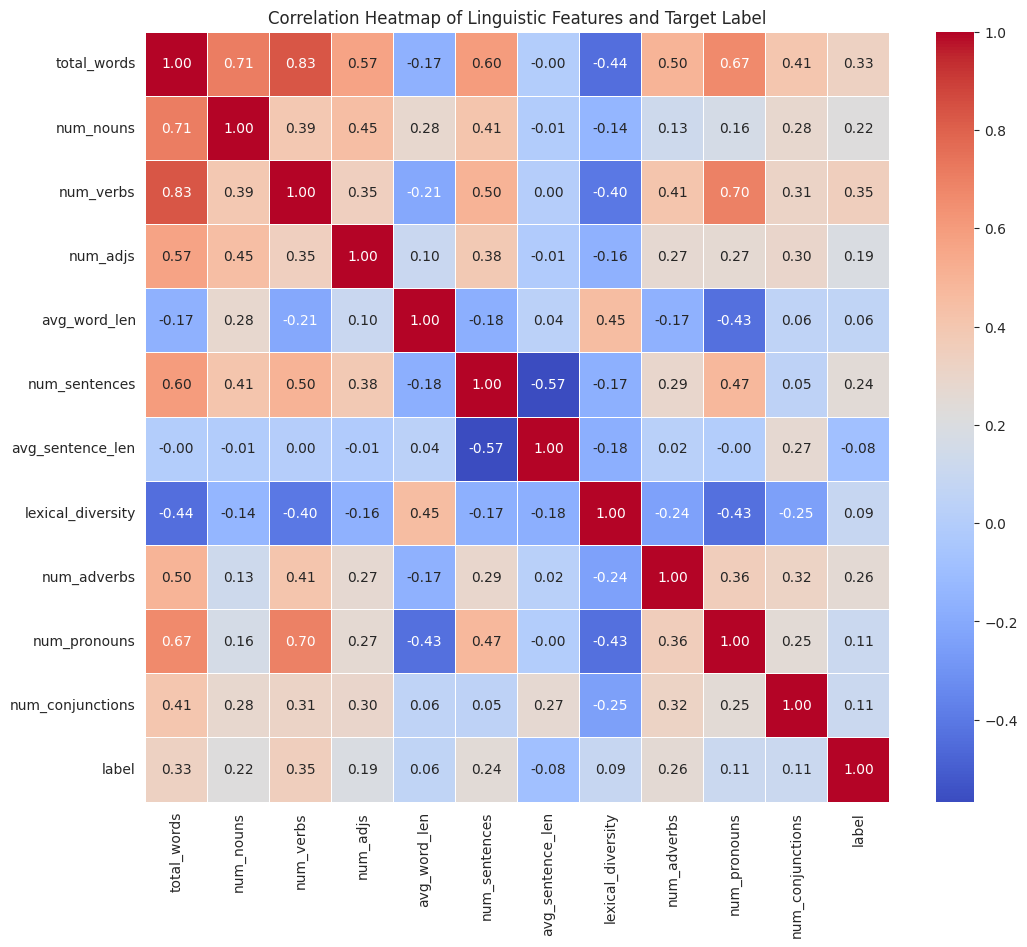

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Identify non-BERT linguistic features for correlation heatmap
# These are the original features + additional linguistic features
linguistic_features_for_corr = [
    'total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len',
    'num_sentences', 'avg_sentence_len', 'lexical_diversity', 'num_adverbs',
    'num_pronouns', 'num_conjunctions'
]

# Ensure these columns exist in train_df_bert and select them
# Filter out any features that might not exist (though they should based on previous steps)
existing_linguistic_features = [f for f in linguistic_features_for_corr if f in train_df_bert.columns]

# Calculate the correlation matrix
correlation_matrix = train_df_bert[existing_linguistic_features + ['label']].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Linguistic Features and Target Label')
plt.show()

## Visualize Comparative Distributions of Key Linguistic Features

### Subtask:
Create comparative distribution plots (histograms or KDEs) for key linguistic features such as 'total_words', 'avg_word_len', and 'num_nouns' using `train_df_bert` and `test_df_bert`.

#### Instructions
1. Select the key linguistic features to visualize: 'total_words', 'avg_word_len', and 'num_nouns'.
2. Iterate through each selected feature.
3. For each feature, create a new figure with a specified size (e.g., 10x6 inches).
4. Generate a histogram with a KDE for the current feature from `train_df_bert`. Use `sns.histplot()` with `kde=True`, a distinct color (e.g., 'blue'), `stat='density'`, and `alpha=0.5`.
5. On the same plot, generate a histogram with a KDE for the current feature from `test_df_bert`. Use `sns.histplot()` with `kde=True`, a different color (e.g., 'red'), `stat='density'`, and `alpha=0.5`.
6. Add a title to the plot, such as 'Distribution of [Feature Name] (Train vs. Test)'.
7. Label the x-axis with the feature name and the y-axis as 'Density'.
8. Add a legend to distinguish between 'Train Data' and 'Test Data'.
9. Display the plot using `plt.show()`.

Comparative Distributions of Key Linguistic Features:


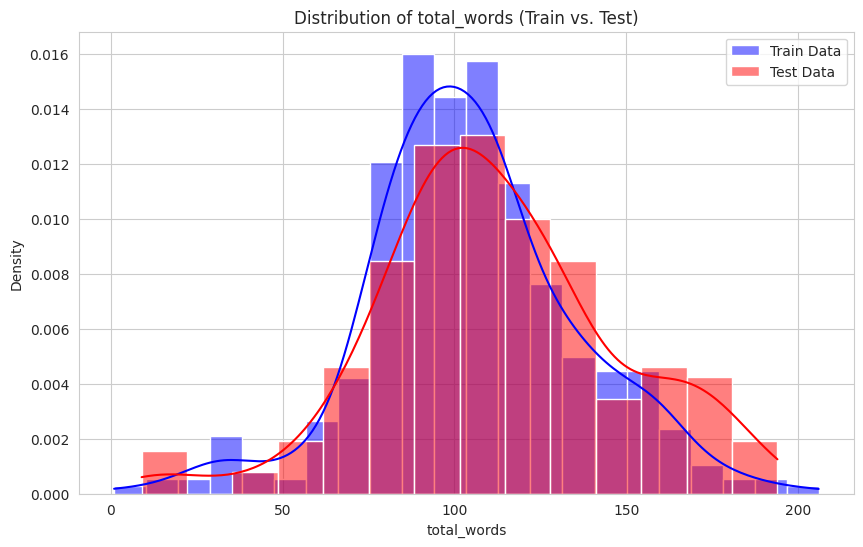

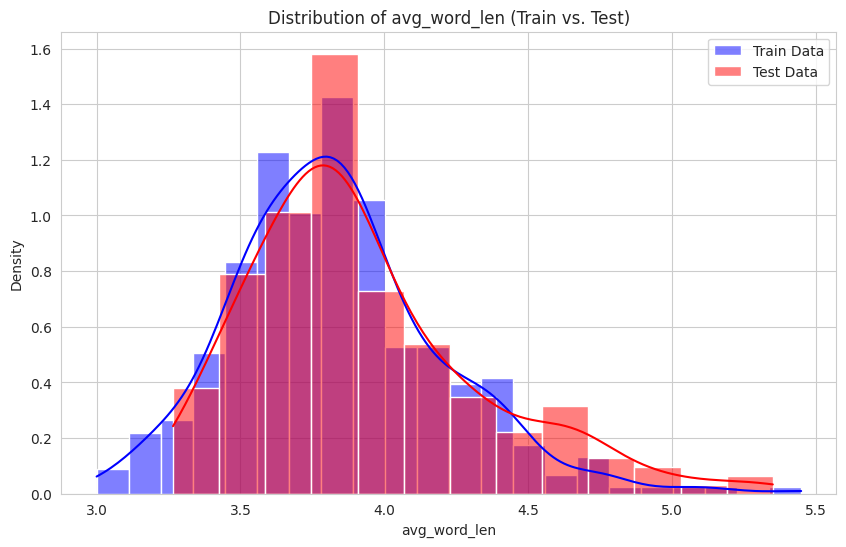

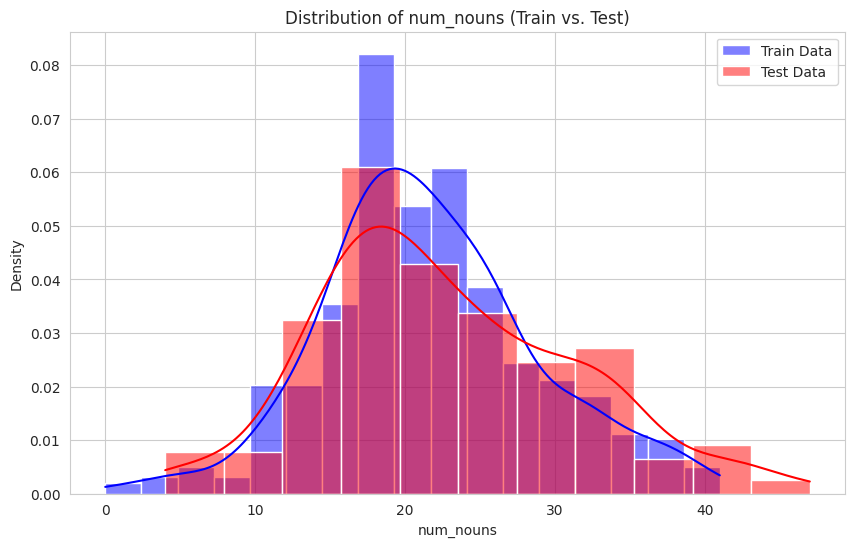

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

selected_linguistic_features = ['total_words', 'avg_word_len', 'num_nouns']

print("Comparative Distributions of Key Linguistic Features:")
for feature in selected_linguistic_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_df_bert[feature], kde=True, color='blue', label='Train Data', stat='density', alpha=0.5)
    sns.histplot(test_df_bert[feature], kde=True, color='red', label='Test Data', stat='density', alpha=0.5)
    plt.title(f'Distribution of {feature} (Train vs. Test)')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Prepare the final training and test feature matrices by dropping unnecessary columns and then print their shapes to confirm the dimensions.



In [11]:
X_train_enhanced = train_df_bert.drop(['text', 'label'], axis=1)
y_train_enhanced = train_df_bert['label']
X_test_enhanced = test_df_bert.drop('text', axis=1)

print("Shapes of the enhanced dataframes:")
print(f"X_train_enhanced: {X_train_enhanced.shape}")
print(f"y_train_enhanced: {y_train_enhanced.shape}")
print(f"X_test_enhanced: {X_test_enhanced.shape}")

print("\nX_train_enhanced Head:")
display(X_train_enhanced.head())
print("\ny_train_enhanced Head:")
display(y_train_enhanced.head())
print("\nX_test_enhanced Head:")
display(X_test_enhanced.head())

Shapes of the enhanced dataframes:
X_train_enhanced: (409, 779)
y_train_enhanced: (409,)
X_test_enhanced: (197, 779)

X_train_enhanced Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,bert_embedding_4,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,110,17,21,7,3.781818,-0.017884,-0.220572,-0.082134,-0.290324,-0.434851,...,-0.062331,-0.370403,0.830012,0.192308,7,13.571429,0.589474,6,12,1
1,159,41,29,12,4.459119,-0.157179,-0.173512,0.235440,-0.179534,0.258938,...,-0.228660,-0.357835,0.725449,-0.235447,6,25.333333,0.657895,6,13,5
2,68,16,10,6,3.838235,-0.059833,-0.192255,0.035728,-0.519021,0.283456,...,-0.405398,-0.512365,0.798833,-0.053746,7,8.428571,0.627119,6,6,0
3,96,22,19,8,4.770833,0.340809,0.140789,0.066631,-0.211851,-0.493405,...,-0.232666,-0.601944,0.534844,0.324819,6,14.333333,0.755814,5,7,9
4,139,23,23,8,3.071942,-0.174814,-0.037933,0.491440,-0.627916,-0.482961,...,-0.222264,-0.721361,0.454301,0.579866,9,13.555556,0.467213,9,24,7



y_train_enhanced Head:


,label
0,3.0
1,3.0
2,2.0
3,2.0
4,3.5



X_test_enhanced Head:


,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,bert_embedding_4,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,-0.349349,...,-0.400321,-0.490371,0.419944,0.314149,1,35.000000,0.657143,4,3,1
1,57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,-0.479770,...,-0.210205,-0.253622,0.250035,0.252116,3,17.666667,0.641509,1,7,5
2,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,-0.114370,...,-0.201813,-0.227299,0.419966,0.473528,2,39.500000,0.620253,2,8,5
3,154,41,19,2,3.785714,0.262115,-0.429694,0.155619,0.560395,-0.112464,...,0.100634,-0.242872,0.252756,0.545471,8,16.625000,0.563910,10,5,5
4,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,-0.258444,...,-0.059260,-0.504291,0.531867,0.192651,1,57.000000,0.736842,5,8,2


## Train and Evaluate RandomForest with Enhanced Features

### Subtask:
Initialize, train, and evaluate a RandomForestRegressor model using the X_train_enhanced and y_train_enhanced data. Calculate and print the Mean Squared Error (MSE) on the training set.


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize RandomForestRegressor
model_rf_enhanced = RandomForestRegressor(random_state=42)

# Train the model
model_rf_enhanced.fit(X_train_enhanced, y_train_enhanced)

# Make predictions on the training data
y_pred_rf_enhanced = model_rf_enhanced.predict(X_train_enhanced)

# Calculate Mean Squared Error (MSE)
mse_rf_enhanced = mean_squared_error(y_train_enhanced, y_pred_rf_enhanced)

# Print the training MSE
print(f"RandomForest with Enhanced features Train MSE: {mse_rf_enhanced:.4f}")

RandomForest with Enhanced features Train MSE: 0.0529


## Train and Evaluate LightGBM with Enhanced Features

### Subtask:
Initialize, train, and evaluate an LGBMRegressor model using the `X_train_enhanced` and `y_train_enhanced` data. Calculate and print the Mean Squared Error (MSE) on the training set.

In [16]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Initialize LGBMRegressor
model_lgb_enhanced = lgb.LGBMRegressor(random_state=42)

# Train the model
model_lgb_enhanced.fit(X_train_enhanced, y_train_enhanced)

# Make predictions on the training data
y_pred_lgb_enhanced = model_lgb_enhanced.predict(X_train_enhanced)

# Calculate Mean Squared Error (MSE)
mse_lgb_enhanced = mean_squared_error(y_train_enhanced, y_pred_lgb_enhanced)

# Print the training MSE
print(f"LightGBM with Enhanced features Train MSE: {mse_lgb_enhanced:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105880
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 779
[LightGBM] [Info] Start training from score 2.910758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

## Compare All Models (Original and BERT-enhanced) and Final Selection

### Subtask:
Compare the training Mean Squared Error (MSE) of all models trained (RandomForest,LightGBM, both with original and BERT-enhanced features) to identify the best performing one based on the lowest MSE. Print all MSEs and declare the overall best model.


In [29]:
print(f"RandomForest Train MSE (Enhanced features): {mse_rf_enhanced:.4f}")
print(f"LightGBM Train MSE (Enhanced features): {mse_lgb_enhanced:.4f}")

# Combine all MSE values for comparison
all_mse_values = {
    'RandomForest_Enhanced': mse_rf_enhanced,
    'LightGBM_Enhanced': mse_lgb_enhanced
}

best_model_name_overall = min(all_mse_values, key=all_mse_values.get)
best_mse_overall = all_mse_values[best_model_name_overall]

print(f"\nThe overall best performing model based on training MSE is {best_model_name_overall} with MSE: {best_mse_overall:.4f}")

RandomForest Train MSE (Enhanced features): 0.0529
LightGBM Train MSE (Enhanced features): 0.0016

The overall best performing model based on training MSE is LightGBM_Enhanced with MSE: 0.0016


## Generate Final Predictions with LightGBM Enhanced

### Subtask:
Use the `model_lgb_enhanced` to make predictions on the `X_test_enhanced` data. Create a submission CSV file (e.g., 'submission_final.csv') containing the 'filename' from `test_df_bert` and the predicted 'label' for the test set.


In [30]:
preds_final = model_lgb_enhanced.predict(X_test_enhanced)

submission_final = pd.DataFrame({'filename': test_df['filename'], 'label': preds_final})
submission_final.to_csv("submission.csv", index=False)

print("Final predictions generated using LightGBM enhanced model.")
print("Submission file created: submission_final.csv")
display(submission_final.head())

Final predictions generated using LightGBM enhanced model.
Submission file created: submission_final.csv


,filename,label
0,audio_141,2.620216
1,audio_114,3.454288
2,audio_17,2.696568
3,audio_76,4.304937
4,audio_156,2.706999


## Save Modified CSV Files

### Subtask:
Save the updated training DataFrame (`train_df_bert`), which now includes all original features, BERT embeddings, and the new linguistic features along with the label, to 'train_features_full.csv'. Also, save the updated test DataFrame (`test_df_bert`), which contains all original features, BERT embeddings, and the new linguistic features, to 'test_features_full.csv' for future reference.


In [25]:
train_df_bert.to_csv('train_features_full.csv', index=False)
test_df_bert.to_csv('test_features_full.csv', index=False)

print("Enhanced train features saved to 'train_features_full.csv'")
print("Enhanced test features saved to 'test_features_full.csv'")

Enhanced train features saved to 'train_features_full.csv'
Enhanced test features saved to 'test_features_full.csv'


## Summary:

### Data Analysis Key Findings
*   The `train_df_bert` DataFrame, which includes all original features, BERT embeddings, and newly engineered linguistic features along with the label, was successfully saved to 'train_features_full.csv'.
*   The `test_df_bert` DataFrame, containing the same comprehensive set of features for the test data (original features, BERT embeddings, and linguistic features), was successfully saved to 'test_features_full.csv'.
*   Both files were saved with `index=False`, ensuring that the DataFrame index was not written to the CSV files.

### Insights or Next Steps
*   The enhanced training and test datasets, now saved as 'train\_features\_full.csv' and 'test\_features\_full.csv', provide a comprehensive and reproducible snapshot of the data used for the final model, ready for future analysis or auditing.
*   These saved files can serve as a baseline for comparing performance against future feature engineering efforts or model refinements.


# Task
Visualize the target label distribution from `train_df` using a histogram and KDE plot. Then, from `train_df_bert` and `test_df_bert`, create comparative distribution plots (histograms or KDEs) for key linguistic features such as 'total_words', 'avg_word_len', and 'num_nouns'. Finally, generate a correlation heatmap for the numerical linguistic features (excluding BERT embeddings) within `train_df_bert`. Summarize the insights gained from these visualizations regarding data characteristics and feature relationships.

## Load Data for Visualization

### Subtask:
Ensure `train_df`, `test_df`, `train_df_bert`, and `test_df_bert` are loaded and available in the environment for visualization. This step will explicitly load `train.csv` and `test.csv` if they are not already loaded from the previous steps, and load the enhanced feature dataframes.


In [33]:
import pandas as pd
import os

# Define BASE_PATH as it was used in previous cells to locate the dataset
BASE_PATH = "/content"

# 1. Load the original training data
train_df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

# 2. Load the original test data
test_df = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))

# 3. Load the enhanced training features from train_features_full.csv
train_df_bert = pd.read_csv('train_features_full.csv')

# 4. Load the enhanced test features from test_features_full.csv
test_df_bert = pd.read_csv('test_features_full.csv')

# 5. Display the first 5 rows and the shape of each loaded DataFrame
print("Original Train DataFrame (train_df) Head:")
display(train_df.head())
print(f"Shape of train_df: {train_df.shape}")

print("\nOriginal Test DataFrame (test_df) Head:")
display(test_df.head())
print(f"Shape of test_df: {test_df.shape}")

print("\nEnhanced Train DataFrame (train_df_bert) Head:")
display(train_df_bert.head())
print(f"Shape of train_df_bert: {train_df_bert.shape}")

print("\nEnhanced Test DataFrame (test_df_bert) Head:")
display(test_df_bert.head())
print(f"Shape of test_df_bert: {test_df_bert.shape}")

Original Train DataFrame (train_df) Head:


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


Shape of train_df: (409, 2)

Original Test DataFrame (test_df) Head:


,filename
0,audio_141
1,audio_114
2,audio_17
3,audio_76
4,audio_156


Shape of test_df: (197, 1)

Enhanced Train DataFrame (train_df_bert) Head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label,bert_embedding_0,bert_embedding_1,bert_embedding_2,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,"My favorite place to visit will be Japan, beca...",110,17,21,7,3.781818,3.0,-0.017884,-0.220572,-0.082134,...,-0.062331,-0.370403,0.830012,0.192308,7,13.571429,0.589474,6,12,1
1,I love to reading on my hobby such reading. Em...,159,41,29,12,4.459119,3.0,-0.157179,-0.173512,0.235440,...,-0.228660,-0.357835,0.725449,-0.235447,6,25.333333,0.657895,6,13,5
2,My favorite place to visit is Mullah Itis near...,68,16,10,6,3.838235,2.0,-0.059833,-0.192255,0.035728,...,-0.405398,-0.512365,0.798833,-0.053746,7,8.428571,0.627119,6,6,0
3,I am going to tell about my hobby. And my hobb...,96,22,19,8,4.770833,2.0,0.340809,0.140789,0.066631,...,-0.232666,-0.601944,0.534844,0.324819,6,14.333333,0.755814,5,7,9
4,This is a tough one. So my bestie of my life i...,139,23,23,8,3.071942,3.5,-0.174814,-0.037933,0.491440,...,-0.222264,-0.721361,0.454301,0.579866,9,13.555556,0.467213,9,24,7


Shape of train_df_bert: (409, 781)

Enhanced Test DataFrame (test_df_bert) Head:


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,bert_embedding_0,bert_embedding_1,bert_embedding_2,bert_embedding_3,...,bert_embedding_764,bert_embedding_765,bert_embedding_766,bert_embedding_767,num_sentences,avg_sentence_len,lexical_diversity,num_adverbs,num_pronouns,num_conjunctions
0,"I love when I love stories Sherlock Holmes, Ar...",39,17,4,1,4.076923,-0.272917,-0.078782,0.133168,0.089993,...,-0.400321,-0.490371,0.419944,0.314149,1,35.000000,0.657143,4,3,1
1,"I have a lot of favorite days, but one of the ...",57,11,9,5,3.649123,0.109049,0.066324,-0.406232,-0.256408,...,-0.210205,-0.253622,0.250035,0.252116,3,17.666667,0.641509,1,7,5
2,My topic is describe the scene of a hospital. ...,85,16,18,3,3.894118,0.083280,-0.206709,-0.031666,-0.131339,...,-0.201813,-0.227299,0.419966,0.473528,2,39.500000,0.620253,2,8,5
3,A playground has a lot of equipment. It typica...,154,41,19,2,3.785714,0.262115,-0.429694,0.155619,0.560395,...,0.100634,-0.242872,0.252756,0.545471,8,16.625000,0.563910,10,5,5
4,The best day of my life are the most days when...,69,13,15,3,4.072464,0.122371,0.104506,0.067356,0.012758,...,-0.059260,-0.504291,0.531867,0.192651,1,57.000000,0.736842,5,8,2


Shape of test_df_bert: (197, 780)
